# Project by cheesecakeMafia

## Basic imports

In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_ta as ta
import missingno

## Let's read the data from the the file and set the first column, which is the date as the index and convert it into datetime format

In [2]:
df = pd.read_csv(r"C:\Users\f2013\Downloads\Projects\Fintinity Project\Data\BankNifty_Data.csv",index_col=0, parse_dates=True)

### Check the structure of the available dataset

In [3]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,18752.20,19118.85,18752.20,19057.80,0
2015-01-05,19155.20,19166.00,18987.70,19017.40,0
2015-01-06,18874.60,18874.60,18388.35,18430.75,0
2015-01-07,18382.55,18482.05,18211.50,18304.25,0
2015-01-08,18587.10,18752.30,18486.20,18701.40,0


### Lets us first replace 0 values with Nan values as it becomes easier to deal with Nan than with 0.

In [4]:
df.replace(0,np.nan,inplace=True)

### Before moving forward lets inspect the data once and drop the rows\columns where the data is ambiguous or missing. We can use the missing number library to help us in that task. 

In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,1784.000000,1784.000000,1784.000000,1784.000000,6.500000e+02
mean,28632.343302,28844.281754,28374.907876,28612.745572,3.493863e+06
std,7323.724950,7360.552535,7285.362752,7327.806497,7.118261e+07
min,13844.450000,13844.450000,13519.900000,13555.700000,3.880000e+04
25%,22972.062500,23165.812500,22733.762500,22959.862500,1.553000e+05
50%,27408.600000,27553.775000,27201.950000,27404.375000,2.095000e+05
75%,34955.300000,35222.837500,34652.887500,34949.925000,3.268000e+05
max,44078.600000,44151.800000,43987.950000,44049.100000,1.798102e+09


### We see that a lot of the data for Volume is missing. Let's run it throught the missingno library function to see it in graphical form. 

<AxesSubplot:>

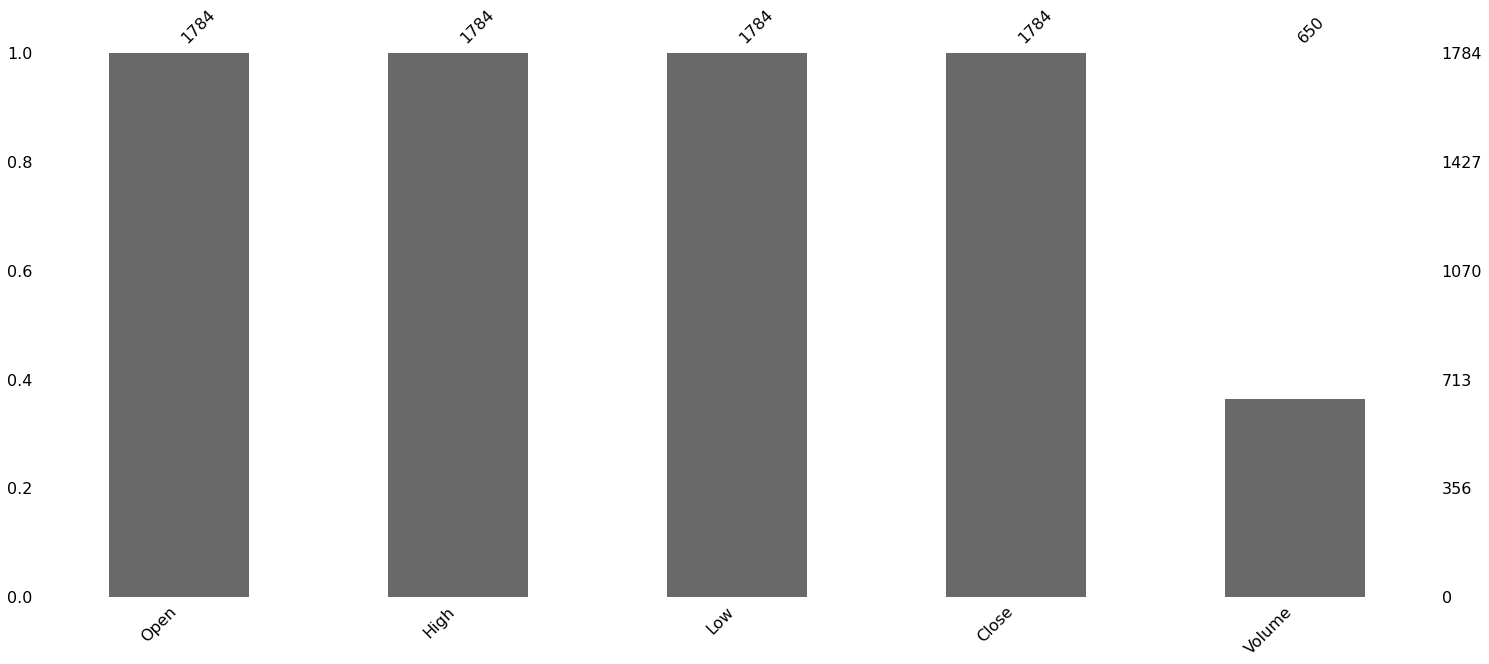

In [6]:
missingno.bar(df)

### We see a we only have ~700 values of Volume. So lets drop the volume column from the analysis. 

In [7]:
df = df.drop(columns=["Volume"])

## Now lets make a final inspection of data using the missingno library again. 

<AxesSubplot:>

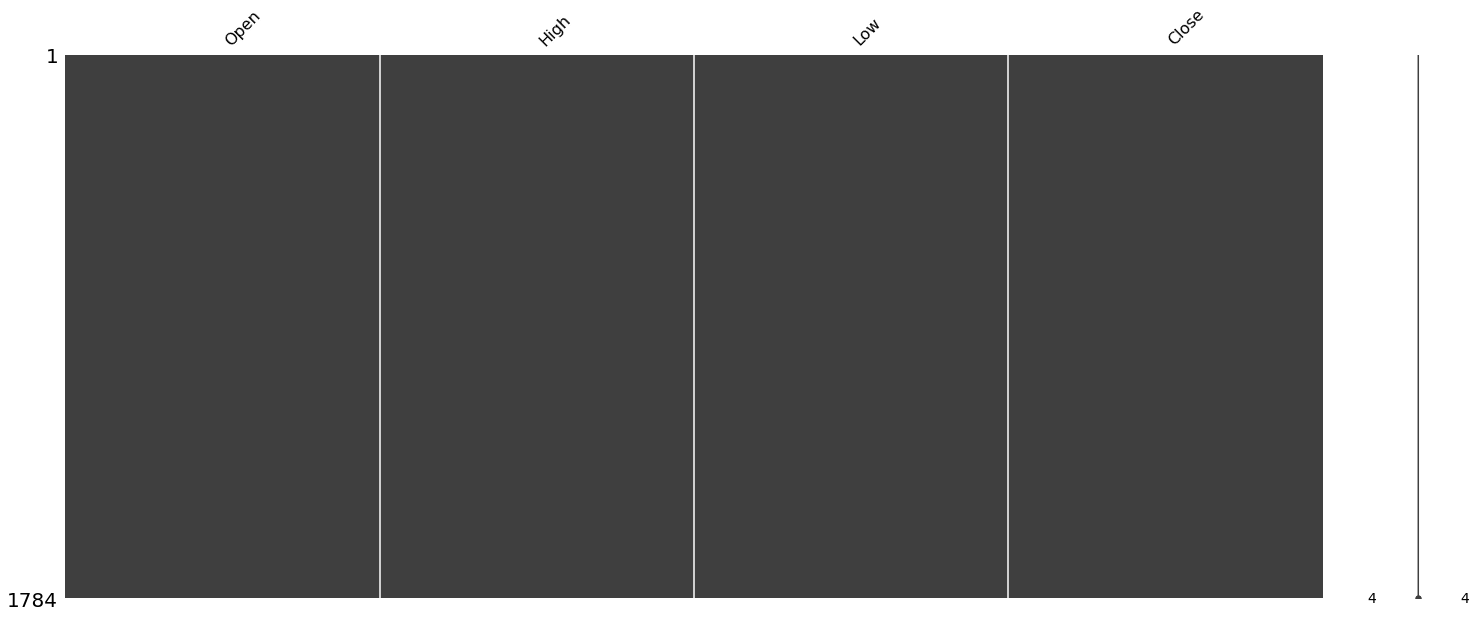

In [8]:
missingno.matrix(df)

## We see we have all the data we need for the analysis and can start with importing indicators from the pandas_ta library. 

In [9]:
window = 5 # One trading week

## Let us define the RSI and Bolinger Bands indicators using the Pandas_TA library

In [10]:
df["RSI"] = ta.rsi(df["Close"], length = window) 
bb = ta.bbands(df["Close"], length=window, std=3)
bb_names = ["Lower_BB","Mid_BB","Upper_BB"]
bb = bb.iloc[:,:3]
bb.columns = bb_names
df = pd.concat([df,bb], axis=1)

## Now, let's define the ADX indicator using the same library

In [11]:
adx = ta.adx(high=df["High"], low=df["Low"],close=df["Close"], length=window)
adx = adx.iloc[:,0]
adx.rename("ADX", inplace=True)
df = pd.concat([df,adx], axis = 1)

### As these indicator will start after taking in 5 days worth of data, let's drop the rows containing NaN values

In [12]:
df.dropna(inplace=True)

### Let's just once check how the dataframe looks using the head function. 

In [13]:
df.head()

,Open,High,Low,Close,RSI,Lower_BB,Mid_BB,Upper_BB,ADX
Date,,,,,,,,,
2015-01-15,19340.45,19410.40,19061.35,19235.65,71.951295,18107.490884,18795.95,19484.409116,22.879320
2015-01-16,19274.15,19275.80,19108.35,19223.15,71.004581,18117.164515,18913.13,19709.095485,30.596047
2015-01-19,19345.65,19434.20,19299.10,19406.05,76.628933,18080.128038,19035.17,19990.211962,38.079513
2015-01-20,19446.80,19808.25,19446.80,19767.05,84.193480,18116.531825,19247.14,20377.748175,46.723840
2015-01-21,19811.85,19964.95,19803.15,19843.25,85.437158,18707.718642,19495.03,20282.341358,53.961497


## Now, let's define the entry signal. First create a column signal with NaN values then use the following logic to get the signal

# Buy Entry signal - When the Low of the day is lower than Lower_BB and the ADX indicator which shows momentum is lower than 35, we get a buy signal

# Sell Entry signal - When the high of the day is higher than Upper_BB and the ADX indicator which shows momentum is lower than 35, we get a sell signal.

In [14]:
df["Signal"] = np.nan

for i in range(len(df.index[:-1])):

    if (df.iloc[i,1] > df.iloc[i,7]) and (df.iloc[i,8] < 35):
        df.iloc[i,9] = -1
    elif (df.iloc[i,2] < df.iloc[i],5) and (df.iloc[i,8] < 35):
        df.iloc[i, 9] = 1
    else:
        df.iloc[i,9] = np.nan

# Buy Exit Signal - When we have a buy position and the RSI indicator gets above 50, we exit.  

# Sell Exit Signal - When we have a sell position and the RSI indicator below above 50, we exit.  

In [15]:
for i in range(len(df.index[:-1])):

    if (df.iloc[i,-1] == 1) and (df.iloc[i,4] > 50):
        df.iloc[i,-1] = 0
    elif (df.iloc[i,-1] == -1) and (df.iloc[i,4] < 50):
        df.iloc[i,-1] = 0

### Number of signals generated. Keep in mind that we can have multiple buys signal one after the other, which just means we will keep holding our position. This doesn't mean we will enter more quantity. Have designed the backtest in such a way as to not enter in the same direction again.

In [16]:
df["Signal"].value_counts()

 0.0    429
 1.0    268
-1.0     14
Name: Signal, dtype: int64

## Now that we have generated the signals, let's use the backtesting module library in python to take virtual trades on the data and return the metrics of our strategy. 

In [17]:
data = df[["Open","High","Low","Close","Signal"]]

In [18]:
data

,Open,High,Low,Close,Signal
Date,,,,,
2015-01-15,19340.45,19410.40,19061.35,19235.65,0.0
2015-01-16,19274.15,19275.80,19108.35,19223.15,0.0
2015-01-19,19345.65,19434.20,19299.10,19406.05,NaN
2015-01-20,19446.80,19808.25,19446.80,19767.05,NaN
2015-01-21,19811.85,19964.95,19803.15,19843.25,NaN
...,...,...,...,...,...
2023-05-08,42796.85,43418.55,42780.30,43284.00,NaN
2023-05-09,43438.55,43533.25,43125.85,43198.15,0.0
2023-05-10,43275.25,43383.65,42822.15,43331.05,0.0


## Here, we used the backtesting module to generate our trades and get the metrics of the strategy. 

## Another important thing to remember is signal is generated on the same day as the by default this module takes position on the next day. This is important to know so as to not confuse it with making a mistake.

In [19]:
# make the imports for hte backtesting library
from backtesting import Backtest
from backtesting.lib import SignalStrategy

C:\Users\f2013\anaconda3\lib\site-packages\backtesting\_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Writting the backtesting framework to generate trades and trade metrics. 

In [20]:
class Trades(SignalStrategy):

    
    def init(self):
        # data = input("Please enter your dataframe:")
        pass

    def next(self):
        if (not self.position.is_long) and (self.data.Signal == 1):
            self.buy(size=25)
        elif (self.position.is_long) and (self.data.Signal == 0):
            self.position.close()
        elif (not self.position.is_short) and (self.data.Signal == -1):
            self.sell(size=25)
        elif (self.position.is_short) and (self.data.Signal == 0):
            self.position.close()
        else:
            pass


bt = Backtest(data, Trades, cash=10_000_000*0.20, commission=0.00025)
stats = bt.run()
stats

Start                     2015-01-15 00:00:00
End                       2023-05-12 00:00:00
Duration                   3039 days 00:00:00
Exposure Time [%]                   51.211268
Equity Final [$]                   2367474.66
Equity Peak [$]                2475109.907187
Return [%]                          18.373733
Buy & Hold Return [%]              127.668678
Return (Ann.) [%]                    2.423637
Volatility (Ann.) [%]                 6.33917
Sharpe Ratio                         0.382327
Sortino Ratio                        0.557157
Calmar Ratio                         0.147739
Max. Drawdown [%]                  -16.404857
Avg. Drawdown [%]                   -1.386697
Max. Drawdown Duration      681 days 00:00:00
Avg. Drawdown Duration       65 days 00:00:00
# Trades                                  118
Win Rate [%]                        70.338983
Best Trade [%]                      10.841306
Worst Trade [%]                    -34.954493
Avg. Trade [%]                    

Run the below cell to get a graphical representation of the backtest with equity curve, PnL and the asset curve.

In [21]:
bt.plot();

## Just a visual analysis shows us that there is a single trade in which we lost more than 30%. So if we keep a stop at 15% that would increase our Sharpe. Let's do that and check our returns

In [22]:
class Trades_with_SL(SignalStrategy):

    
    def init(self):
        # data = input("Please enter your dataframe:")
        pass

    def next(self):

        price = self.data.Close[-1]

        if (not self.position.is_long) and (self.data.Signal == 1):
            self.buy(sl=0.85*price, size=25)
        elif (self.position.is_long) and (self.data.Signal == 0):
            self.position.close()
        elif (not self.position.is_short) and (self.data.Signal == -1):
            self.sell(sl=1.15*price, size=25)
        elif (self.position.is_short) and (self.data.Signal == 0):
            self.position.close()
        else:
            pass


bt_1 = Backtest(data, Trades_with_SL, cash=10_000_000, commission=0.00025)
stats_1 = bt_1.run()
stats_1

Start                     2015-01-15 00:00:00
End                       2023-05-12 00:00:00
Duration                   3039 days 00:00:00
Exposure Time [%]                   49.577465
Equity Final [$]              10403559.952812
Equity Peak [$]                    10511195.2
Return [%]                             4.0356
Buy & Hold Return [%]              127.668678
Return (Ann.) [%]                    0.563263
Volatility (Ann.) [%]                1.155478
Sharpe Ratio                         0.487472
Sortino Ratio                        0.718488
Calmar Ratio                         0.319802
Max. Drawdown [%]                   -1.761286
Avg. Drawdown [%]                   -0.358062
Max. Drawdown Duration     1103 days 00:00:00
Avg. Drawdown Duration       94 days 00:00:00
# Trades                                  119
Win Rate [%]                        69.747899
Best Trade [%]                      10.841306
Worst Trade [%]                    -18.106956
Avg. Trade [%]                    

#### Run the below cell to get a graphical representation of the backtest with equity curve, PnL and the asset curve.

In [23]:
bt_1.plot();

## We have managed to decrease the max DD to under 2%. Although, returns did decrease, but our Sharpe ration managed to increase from 0.38 to 0.48. 

# Further ideas - We could run a Monte Carlo analysis on the trade returns and do a million iterations and then based on the bottom 5 percentile DD and equity curve, decide how much should we be risking per trade. Right now we are using a margin of 20% per trade. 

In [24]:
returns = stats_1["_trades"]["ReturnPct"]
returns

0      0.003377
1      0.041353
2      0.007279
3     -0.001771
4      0.017307
         ...   
114    0.008577
115    0.002909
116    0.006127
117    0.004524
118    0.016836
Name: ReturnPct, Length: 119, dtype: float64

## Next, let's try and optimise the Sharpe ration by using a different stop loss everytime using the same backtesting module. 

In [25]:
class Trades_opt(SignalStrategy):

    buy_stop = 0.9
    sell_stop = 1.1

    def init(self):
        # data = input("Please enter your dataframe:")
        # self.data = data
        pass

    def next(self):

        price = self.data.Close[-1]

        if (not self.position.is_long) and (self.data.Signal == 1):
            self.buy(sl=self.buy_stop*price, size=25)
        elif (self.position.is_long) and (self.data.Signal == 0):
            self.position.close()
        elif (not self.position.is_short) and (self.data.Signal == -1):
            self.sell(sl=self.sell_stop*price, size=25)
        elif (self.position.is_short) and (self.data.Signal == 0):
            self.position.close()
        else:
            pass


bt_opt = Backtest(data, Trades_opt, cash=10_000_000, commission=0.00025)
stats_opt = bt_opt.run()
# stats_opt

## Optimizing the buy and sell stop

In [26]:
stats_opt = bt_opt.optimize(buy_stop = list(np.arange(0.8,1,0.01)), sell_stop = list(np.arange(1.01,1.21,0.01)), maximize="Sharpe Ratio") 

C:\Users\f2013\anaconda3\lib\site-packages\backtesting\backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()


  0%|          | 0/16 [00:00<?, ?it/s]

In [27]:
stats_opt

Start                     2015-01-15 00:00:00
End                       2023-05-12 00:00:00
Duration                   3039 days 00:00:00
Exposure Time [%]                   48.225352
Equity Final [$]              10446791.267812
Equity Peak [$]                   10538237.99
Return [%]                           4.467913
Buy & Hold Return [%]              127.668678
Return (Ann.) [%]                    0.622485
Volatility (Ann.) [%]                1.147371
Sharpe Ratio                         0.542532
Sortino Ratio                        0.803769
Calmar Ratio                         0.411267
Max. Drawdown [%]                   -1.513581
Avg. Drawdown [%]                   -0.334159
Max. Drawdown Duration     1103 days 00:00:00
Avg. Drawdown Duration       86 days 00:00:00
# Trades                                  120
Win Rate [%]                        68.333333
Best Trade [%]                      10.841306
Worst Trade [%]                    -18.106956
Avg. Trade [%]                    

In [28]:
stats_opt._strategy

<Strategy Trades_opt(buy_stop=0.8600000000000001,sell_stop=1.01)>

## We need to keep a buy stop at 14% below and a sell stop at 1 % above our entry price for the best Sharpe according to the optimising framwork. 

## Next, we could do the same thing with Take profit and optimise the Sharpe even further but I feel like that would be overfitting to the data and hence not generate greater Sharpe in the forward testing. 

# Inconclusion, I would like to point out that on the daily time frame, this strategy will not work very well as the Sharpe ratio is below 1, as market have a upward bias but on intraday data, we could perform better. Maybe a 1:1 Risk reward and a 70-75% win rate would be possible. But that needs further testing.  